# Unit 3: Demographic Recommendations

In this section we leave the boring field of unpersonalized content and do our first tiny steps towards any personalized content. But, before tailoring content to individuals we first tailor content to groups of individuals that by some criteria seem to be similar and - assumingly - consuming similar content.

We distinguish individuals into groups by using demographic information we have on these individuals. This can be any of
* age
* gender
* citizenship
* income
* etc.

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
from typing import Dict, List
import os
import sys
import math

import numpy as np
import scipy as sp
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

In [42]:
from recsys_training.data import Dataset
from recsys_training.evaluation import get_relevant_items

In [43]:
ml100k_ratings_filepath = '../data/raw/ml-100k/u.data'
ml100k_user_filepath = '../data/raw/ml-100k/u.user'

In [61]:
data = Dataset(ml100k_ratings_filepath)
data.rating_split(seed=42)

MovieLens also provides some demographic data on users along with the datasets. We will user _age_ and _gender_ in this tutorial to create different groups.

In [140]:
users = pd.read_csv(ml100k_user_filepath, sep='|', header=None,
                    names=['user', 'age', 'gender', 'occupation', 'zip'])

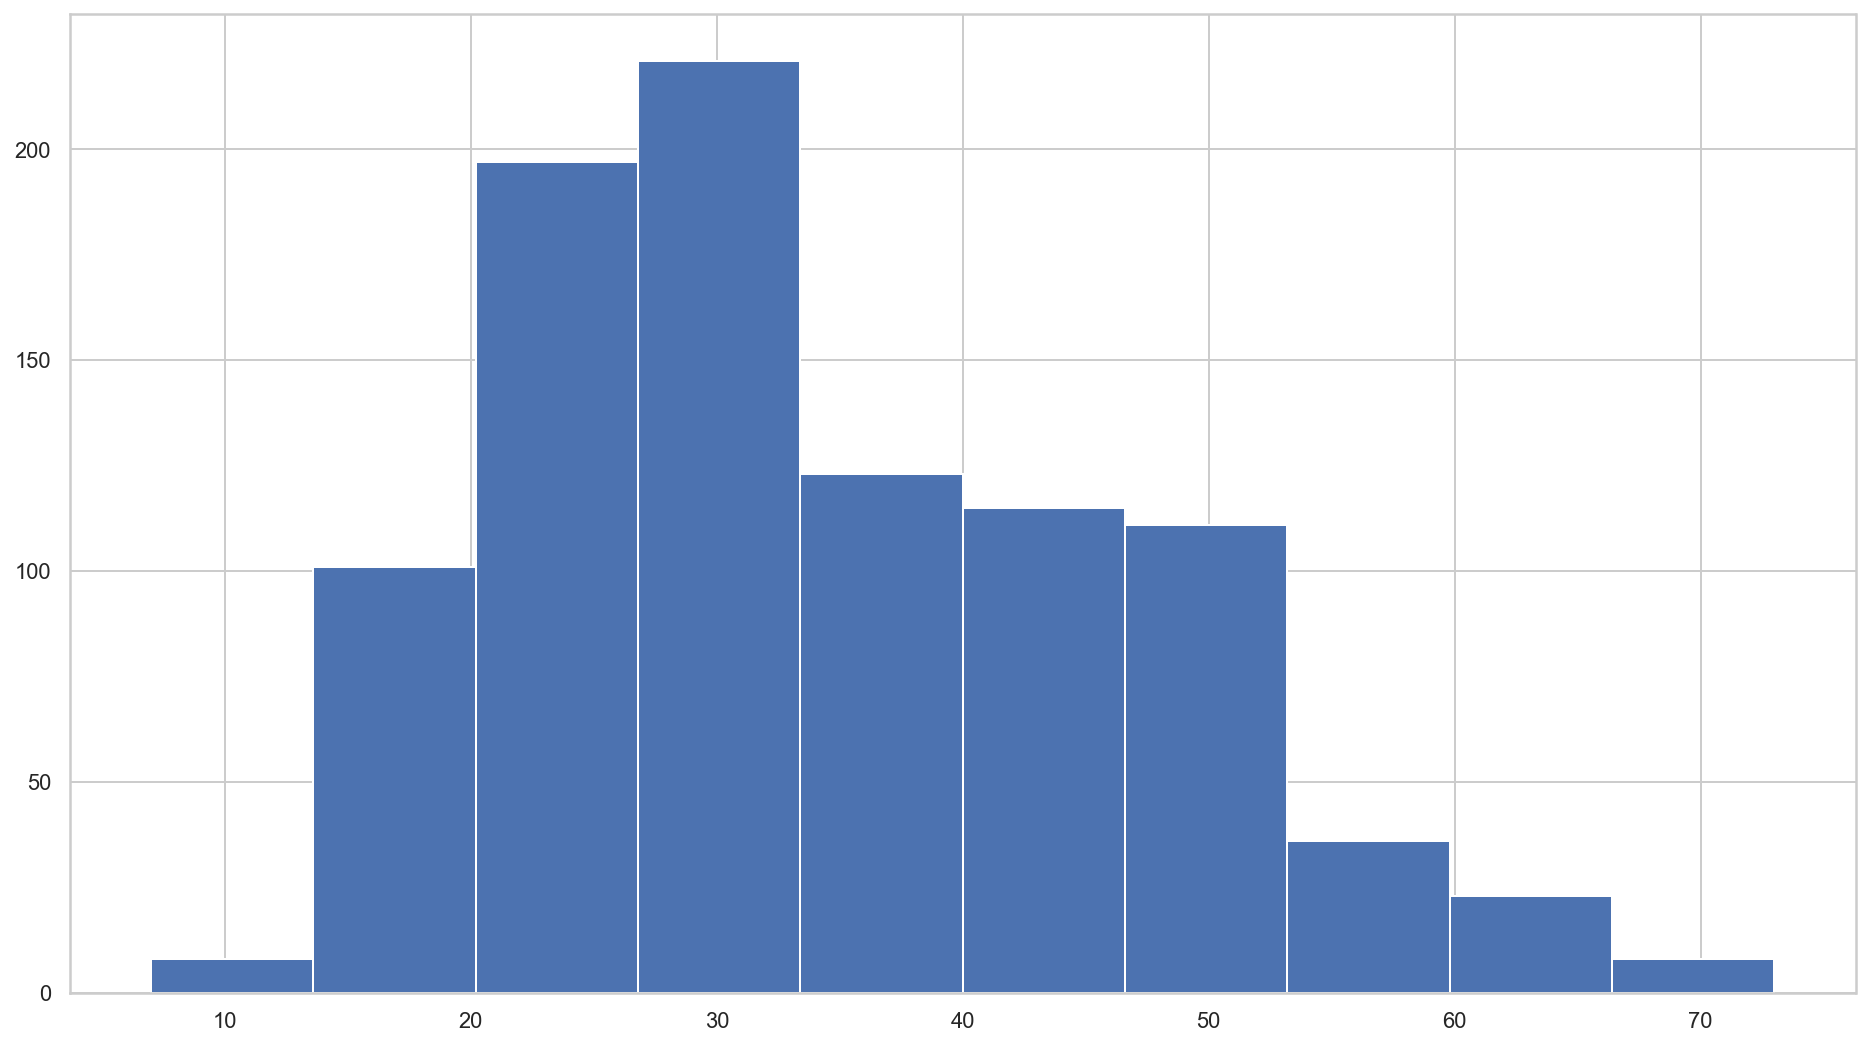

In [141]:
users.age.hist()

Let's define 6 user groups by splitting by gender and age class (arbitrary split)

In [142]:
gender_groups = ['M', 'F']
age_groups = [(7, 24), (25, 49), (50, 73)]

user_groups = list(itertools.product(gender_groups, age_groups))
user_group_indices = range(len(user_groups))
user_groups = dict(zip(user_group_indices, user_groups))

In [143]:
user_groups

{0: ('M', (7, 24)),
 1: ('M', (25, 49)),
 2: ('M', (50, 73)),
 3: ('F', (7, 24)),
 4: ('F', (25, 49)),
 5: ('F', (50, 73))}

In [144]:
def assign_group(row, age_groups=age_groups):
    for age_group in age_groups:
        if row['age'] >= age_group[0] and row['age'] <= age_group[1]:
            break
    return (row['gender'], age_group)

In [145]:
users['group'] = users.apply(lambda row: assign_group(row, age_groups), axis=1)

In [146]:
users['group'] = users['group'].map(lambda val: list(user_groups.values()).index(val))

In [147]:
users['group'].value_counts()

1    413
4    171
0    166
2     91
3     68
5     34
Name: group, dtype: int64

In [148]:
group_popularities = dict.fromkeys(user_group_indices)

In [149]:
N = 10

In [150]:
for group_idx in user_group_indices:
    group_members = users[users['group'] == group_idx]['user'].values
    group_ratings = data.train_ratings[data.train_ratings['user'].isin(group_members)]
    group_popularities[group_idx] = group_ratings.item.value_counts().index.values[:N]

In [151]:
group_popularities

{0: array([288, 181, 258,  50, 294, 100, 121,  56,   7, 117]),
 1: array([ 50, 181, 100,   1, 258, 174, 121, 222, 294, 286]),
 2: array([286, 100, 300, 302, 127, 294,  50, 289, 269, 313]),
 3: array([288, 294, 121, 181, 258, 300,  50, 111, 313, 748]),
 4: array([ 50, 286, 294, 258, 100, 300, 181, 288,   1,  98]),
 5: array([286,  50, 300, 100, 269, 237,   9, 285, 127, 321])}

## Perform Popularity Recommendation in these Groups

**Task:** Adapt the MAP@10 commputation from the popularity recommendation notebook accordingly and compute the $MAP@10$ for demographic recommendations

In [152]:
relevant_items = get_relevant_items(data.test_ratings)

In [153]:
user_group_map = dict(zip(users['user'].values, users['group'].values))

Computing $MAP@10$

In [154]:
users = relevant_items.keys()
prec_at_N = dict.fromkeys(users)

for user in users:
    user_group = user_group_map[user]
    recommendations = group_popularities[user_group]
    hits = np.intersect1d(recommendations,
                          relevant_items[user])
    prec_at_N[user] = len(hits)/N

In [155]:
np.mean(list(prec_at_N.values()))

0.10117021276595746

What is the $MAP@10$ for ea. specific group?

In [156]:
group_maps = dict.fromkeys(user_group_indices, list())
for user in users:
    group_maps[user_group_map[user]].append(prec_at_N[user])
for group in user_group_indices:
    group_maps[group] = np.mean(group_maps[group])

In [157]:
group_maps

{0: 0.10117021276595746,
 1: 0.10117021276595746,
 2: 0.10117021276595746,
 3: 0.10117021276595746,
 4: 0.10117021276595746,
 5: 0.10117021276595746}